## This notebook implements a unit test for phantom estimation by emission equation inversion.

The notebook contains configurations selected such that total variation (TV) of true phantom is equal to 0.
The observations are constructed synthetically by solving forward problem.

- both inversion with known exitation Dvar (taken as forward soluiton of exitation solution with known phantom) and iterative inversion which start with exitation without phantom converge to 12% and 16% respectively.

- by adding binary projection to the estimated phantom we managed to get exact reconstruction.


In [1]:
import fenics as fem

# import mshr
import numpy as np
import math 

import scipy
import scipy.sparse as sp
import scipy.optimize as spo
from scipy.interpolate import RectBivariateSpline
import scipy.interpolate as spi

import cvxpy as cp 
import mosek 

import matplotlib.pyplot as plt

from IPython import display
import time
from tqdm import trange, tqdm

#### Main CONFIG VARIABLES

In [2]:
# paralelepiped enclosing the phantom 
lb_x = 0.0
lb_y = 0.0
lb_z = 0.0

rb_x = 1.3 # cm
rb_y = 1.3 # cm
rb_z = 1.4 # cm


# phantom support - a polytope in the form [x_l,x_r] x [y_l,y_r] x [z_l, z_r]
x_l     = 0.25
x_r     = 1.05
y_l     = 0.25
y_r     = 1.05
z_l     = 0.2
z_r     = 1.1   

# x_l     = 0.7
# x_r     = 1.9
# y_l     = 0.7
# y_r     = 1.9
# z_l     = 0.2
# z_r     = 1.1   


# number of elements
# 30# 29#
Nel_x_low = 22
Nel_y_low = 22
Nel_z_low = 24

Nel_x = 22
Nel_y = 22
Nel_z = 24
# Nel_x = Nel_y = Nel_z = 30
# Nel_x = Nel_y = Nel_z = 14 
# Nel_x = Nel_y = Nel_z = 30

degree = 1    # polynomial degree of elements


# number of elements for a boundary layer width
bound_num_el = 3

# Define supports for local Total Variation regularization 
Nc_x = 16
Nc_y = 16
Nc_z = 16

In [3]:
# paralelepiped enclosing the phantom 
lb_x = 0.0
lb_y = 0.0
lb_z = 0.0

rb_x = 1.2 # cm
rb_y = 1.2 # cm
rb_z = 1.4 # cm


# phantom support - a polytope in the form [x_l,x_r] x [y_l,y_r] x [z_l, z_r]
x_l     = 0.2
x_r     = 1.0
y_l     = 0.2
y_r     = 1.0
z_l     = 0.2
z_r     = 1.2


# number of elements
Nel_x_low = 22
Nel_y_low = 22
Nel_z_low = 24

# 30# 29#
Nel_x = 22
Nel_y = 22
Nel_z = 24
# Nel_x = Nel_y = Nel_z = 24
# Nel_x = Nel_y = Nel_z = 14
# Nel_x = Nel_y = Nel_z = 26

degree = 1    # polynomial degree of elements


# number of elements for a boundary layer width
bound_num_el = 3

# Define supports for local Total Variation regularization 
Nc_x = 12
Nc_y = 12
Nc_z = 14

In [4]:
(rb_x-lb_x)/Nel_x

0.05454545454545454

In [5]:
(rb_x-lb_x)/Nel_x*3

0.16363636363636364

#### DOMAIN / FEM setup 

In [6]:
PROBLEM = '3D'
# Create mesh
# 2D mesh
if PROBLEM == '2D':
    nsteps = 3
    coordinate_degree = 1
    gdim = 2
    mesh = fem.UnitDiscMesh.create(fem.MPI.comm_world, nsteps, coordinate_degree, gdim)
    fem.plot(mesh)
    #mesh = fem.RectangleMesh(fem.Point(lb_x, lb_y), fem.Point(rb_x, rb_y), Nel_x, Nel_y)
    #elements = 'triangle'

# 3D mesh
if PROBLEM == '3D':
    # geometry = mshr.Cylinder(fem.Point((lb_x+rb_x)/2,(lb_y+rb_y)/2,lb_z), fem.Point((lb_x+rb_x)/2,(lb_y+rb_y)/2,rb_z), radius, radius)
    # mesh = mshr.generate_mesh(geometry, 15)    
    mesh = fem.BoxMesh(fem.Point(lb_x, lb_y, lb_z), fem.Point(rb_x, rb_y, rb_z), Nel_x, Nel_y, Nel_z)
    mesh_low = fem.BoxMesh(fem.Point(lb_x, lb_y, lb_z), fem.Point(rb_x, rb_y, rb_z), Nel_x_low, Nel_y_low, Nel_z_low)

    elements = 'tetrahedron'

#### Generating synthetic observations

In [7]:
# define Sigma to be an integration area where observations are present.
# This is done by defining marker function, i.e., binary labels for grid nodes where observations are given. 
# Note: In a case considered here this is a boundary of a 2D or 3D domain 

# marker function for observed nodes. Defines logical expression for labeling such nodes.
# Note: use <near> instead of == (equality sign) to avoid problem with numerical rounding.
# Note: use on_boundary marker to be sure only boundary nodes would be considered.
# Note: x[0] defines first coordinate of node x, x[1] - the second, x[2] - the third and so on, i.e., (x,y)=(x[0],x[1])
# Note: to define marker you can use logical operations (e.g., &&, ||) and binary operations (>, <, sqrt, near, etc.)
# Note: the present approach will compile marker function string into efficient C++ code, 
# however it is also possible to write Python class to be a marker function (it will be slower but more epressive). 
# More details with examples can be found here: https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html

top_boundary_marker = fem.CompiledSubDomain(f'(near(x[2], {lb_z}) || near(x[2], {rb_z}) || near(x[1], {rb_y}) || near(x[1], {lb_y}) || near(x[0], {rb_x}) || near(x[0], {lb_x}))  && on_boundary')
observation_marker = fem.CompiledSubDomain(f'(near(x[2], {rb_z}) || near(x[1], {rb_y}) || near(x[1], {lb_y}) || near(x[0], {rb_x}) || near(x[0], {lb_x}))  && on_boundary')

eps = 1e-10
lbx_marker = lb_x + bound_num_el*(rb_x-lb_x)/Nel_x_low + eps
rbx_marker = rb_x - bound_num_el*(rb_x-lb_x)/Nel_x_low - eps

lby_marker = lb_y + bound_num_el*(rb_y-lb_y)/Nel_y_low + eps
rby_marker = rb_y - bound_num_el*(rb_y-lb_y)/Nel_y_low - eps

lbz_marker = lb_z + bound_num_el*(rb_z-lb_z)/Nel_z_low + eps
rbz_marker = rb_z - bound_num_el*(rb_z-lb_z)/Nel_z_low - eps

near_boundary_marker = fem.CompiledSubDomain(f'(x[0]<{lbx_marker} || x[0]> {rbx_marker}) ||'+
                                             f'(x[1]<{lby_marker} || x[1]> {rby_marker}) ||'+
                                             f'(x[2]<{lbz_marker} || x[2]> {rbz_marker})')
print('WARNING: SUPPORT OF mu_axf must be in ', '[', lbx_marker, ',', rbx_marker, ']', lby_marker, rby_marker, lbz_marker, rbz_marker)
sub_domains = fem.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
sub_domains.set_all(0)
top_boundary_marker.mark(sub_domains, 1)
dSigma = fem.ds(subdomain_id=1, subdomain_data=sub_domains, domain=mesh)


In [8]:
# Define function spaces
P1 = fem.FiniteElement('P', elements, degree)
Q  = fem.FunctionSpace(mesh, P1) 
Q_low  = fem.FunctionSpace(mesh_low, P1)

dofs = Q.tabulate_dof_coordinates()
dofs_low = Q_low.tabulate_dof_coordinates()

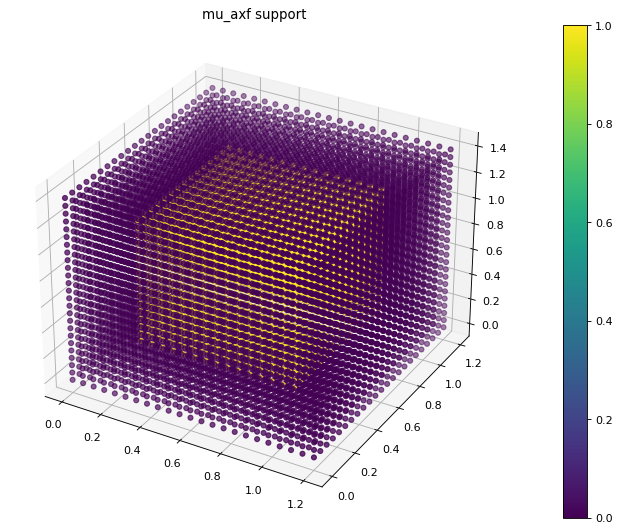

In [9]:
#DEFINE SUPPORT OF mu_axf - a polytope in the form [x_l,x_r] x [y_l,y_r] x [z_l, z_r]
if (x_l < lbx_marker or x_r > rbx_marker or y_l < lby_marker or y_r > rby_marker or z_l < lbz_marker or z_r > rbz_marker): 
    print('WARNING: SUPPORT OF mu_axf - [x_l,x_r] x [y_l,y_r] x [z_l, z_r] should be in the complement of near_boundary_marker!')

XiPhantom = fem.Function(Q)

def InsideCube(x,y,z,lb,rb):
    if rb[0]==rb_x:
        cond_x = (x <= rb[0] and x >= lb[0])
    else:
        cond_x = (x < rb[0] and x >= lb[0])
    
    if rb[1]==rb_y:    
        cond_y = (y <= rb[1] and y >= lb[1])
    else:
        cond_y = (y < rb[1] and y >= lb[1])
    
    if rb[2] == rb_z: 
        cond_z = (z <= rb[2] and z >= lb[2])
    else: 
        cond_z = (z < rb[2] and z >= lb[2])
        
    if cond_x and cond_y and cond_z:
        return 1
    return 0

for i in range(dofs.shape[0]): 
    if InsideCube(dofs[i,0],dofs[i,1],dofs[i,2],[x_l,y_l,z_l],[x_r,y_r,z_r]): 
        XiPhantom.vector()[i] = 1
    else:
        XiPhantom.vector()[i] = 0
        
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
img = fem.plot(XiPhantom)
plt.colorbar(img)
tmp = plt.title('mu_axf support')

In [10]:
def construct_TV_cubes_old(Nc_x, Nc_y, Nc_z):
    Cubes_xcoord = np.linspace(lb_x, rb_x, Nc_x+1, endpoint=True) 
    Cubes_ycoord = np.linspace(lb_y, rb_y, Nc_y+1, endpoint=True) 
    Cubes_zcoord = np.linspace(lb_z, rb_z, Nc_z+1, endpoint=True) 
    TV_cubes_index = np.zeros(shape=[0, dofs.shape[0]],dtype=int)#Nc_x*Nc_y*Nc_z])

    for jx in range(1,len(Cubes_xcoord)):
        for jy in range(1,len(Cubes_ycoord)):
            for jz in range(1,len(Cubes_zcoord)):
                lb_tmp = np.array([Cubes_xcoord[jx-1],Cubes_ycoord[jy-1],Cubes_zcoord[jz-1]])
                rb_tmp = np.array([Cubes_xcoord[jx],Cubes_ycoord[jy],Cubes_zcoord[jz]])
                tmp = np.zeros(dofs.shape[0],dtype=int)
                for ii in range(dofs.shape[0]):
                    tmp[ii] = InsideCube(dofs[ii,0],dofs[ii,1],dofs[ii,2],lb_tmp,rb_tmp)

                TV_cubes_index = np.append(TV_cubes_index,[tmp],axis=0)
    return TV_cubes_index

def construct_TV_cubes(Nc_x, Nc_y, Nc_z, dofs):
    len_x = (rb_x - lb_x) / Nc_x
    len_y = (rb_y - lb_y) / Nc_y
    len_z = (rb_z - lb_z) / Nc_z

    TV_cubes_index = np.zeros(shape=[Nc_x*Nc_y*Nc_z, dofs.shape[0]], dtype=int)

    for ii in range(dofs.shape[0]):
        jx = np.min([np.floor(dofs[ii,0] / len_x), Nc_x-1])
        jy = np.min([np.floor(dofs[ii,1] / len_y), Nc_y-1])
        jz = np.min([np.floor(dofs[ii,2] / len_z), Nc_z-1])

        cube_ind = int(jx*Nc_y*Nc_z + jy*Nc_z + jz)

        TV_cubes_index[cube_ind, ii] = 1
    return TV_cubes_index

# COMPUTE supports for local Total Variation regularization 
TV_cubes_index = construct_TV_cubes(Nc_x, Nc_y, Nc_z, dofs)

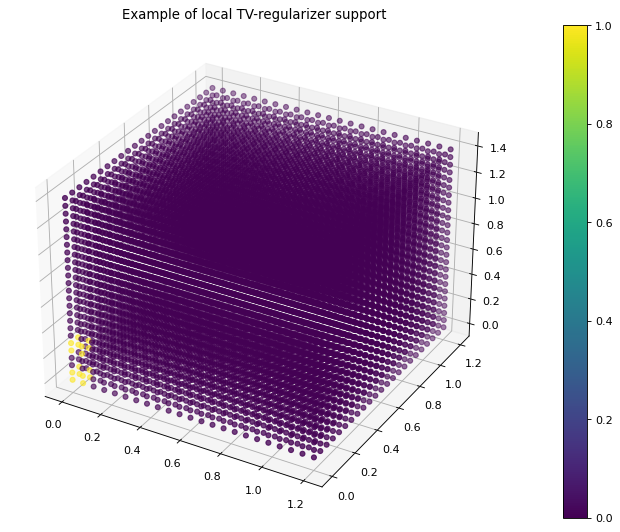

In [11]:
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
tmp = fem.Function(Q)
tmp.vector()[:] = TV_cubes_index[2,:]+TV_cubes_index[0,:]
img = fem.plot(tmp)
plt.colorbar(img)
tmp = plt.title('Example of local TV-regularizer support')

#### COEFFICIENTS & Bilinear FORMS (weak form) 

In [12]:
# DEFINE coefficents for EXCITATION EQ
# absorption coefficent of the medium at fluorophore excitation wl
mu_axi = fem.Function(Q)
# absoption of Liposyne at 785nm (ICG excitation)
mu_axi.vector()[:] = 0.023 * np.ones(mu_axi.vector()[:].shape)

# absorption coefficent due to fluorophore at fluorophore excitation wl
mu_axf = fem.Function(Q)
#absoption of ICG at 785nm: depends on concetration, approx. 0.5 per 1 micromolar 
ICG_absoption_coeff = fem.Constant(0.5)
# print('TODO: drop ICG_absorption to 0.2')
# support of ICG concentration in the domain 
mu_axf.vector()[:] = ICG_absoption_coeff*XiPhantom.vector()[:]

# scattering coefficent of the medium at fluorophore excitation wl
mu_sxp = fem.Function(Q)
# scattering of Liposyne at 785nm 
mu_sxp.vector()[:] = 9.84 * np.ones(mu_sxp.vector()[:].shape)

# diffusion coefficient 
dx = 1/(3*(mu_axi + mu_axf + mu_sxp))
# print('NOTE: dropped mu_axf from Dx')
# dx = 1/(3*(mu_axi + mu_sxp))

#absoption coefficient 
kx = mu_axi + mu_axf

#Bilinear form for the weak formulation of the EXCITATION EQ 
def ax_form(u,v):
    return dx*fem.dot(fem.grad(u), fem.grad(v))*fem.dx + kx*u*v*fem.dx     + 0.5*g*u*v*fem.ds

#EXCITATION EQ without mu_axf (e.g. no fluorophore ) 
def ax_nomuaxf_form(u,v):
    return dx*fem.dot(fem.grad(u), fem.grad(v))*fem.dx + mu_axi*u*v*fem.dx + 0.5*g*u*v*fem.ds

In [13]:
#EMISSION EQ
# absorption coefficent of the medium at fluorophore emission wl
mu_ami = fem.Function(Q)
# absoption of Liposyne at 830nm (ICG emission) 
mu_ami.vector()[:] = 0.0289 * np.ones(mu_ami.vector()[:].shape)

# absorption coefficent due to fluorophore at fluorophore emission wl 
mu_amf = fem.Function(Q)
# we assume that there is no quenching (Donal:ICG concentration must be below 10-15 micromolar depending on the medium ICG is enclosed in)
mu_amf.vector()[:] = np.zeros(mu_amf.vector()[:].shape)

# scattering coefficent of the medium at fluorophore emission wl 
mu_smp = fem.Function(Q)
# scattering of Liposyne at 830nm 
mu_smp.vector()[:] = 9.84 * np.ones(mu_smp.vector()[:].shape)

# diffusion coefficient 
dm = 1/(3*(mu_ami + mu_amf + mu_smp))
#absoption coefficient 
km = mu_ami + mu_amf

#gamma for the Robin boundary condition comes from Table 1 of this paper for air / Liposyne interface: 
#https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-10-15-653&id=69564 
g = fem.Constant(2.5156)
#ICG quantum efficiency 
Gm = fem.Constant(0.016)

#Bilinear form for the weak formulation of the EMISSION EQ
def am_form(u,v):
    return dm*fem.dot(fem.grad(u), fem.grad(v))*fem.dx + km*u*v*fem.dx + 0.5*g*u*v*fem.ds

### SOURCE term

In [14]:
class SourceExpression(fem.UserExpression):
    def eval(self, value, x):
        value[0] = 0
#         value[1] = 0
        if PROBLEM == '2D':
            if (abs((lb_x+rb_x)/2.0 - x[0]) < 0.5) & fem.near(x[1], lb_y):
                value[0] = np.sin(np.pi*x[0])

        if PROBLEM == '3D':
            if fem.near(x[2], rb_z):
                # value[0] = 1e3*(20+10*np.sin(np.pi*x[0]))
                value[0] = 1e4*np.exp(-(x[0]-(rb_x+lb_x)/2)**2/0.35 - (x[1] - (rb_y+lb_y)/2)**2/0.35)  
                # value[0] = (20+10*np.sin(np.pi*x[0]))

    def value_shape(self):
        return ()

trueSource = fem.interpolate(SourceExpression(), Q)   # source

### SOURCE term (from real data)

In [15]:
res = 100
def Trace(func, z):
    xx = np.arange(lb_x,rb_x,(rb_x-lb_x)/res)
    yy = np.arange(lb_y,rb_y,(rb_y-lb_y)/res)
    val2D = np.zeros((xx.shape[0],yy.shape[0]))
    for i in range(xx.shape[0]): 
        for j in range(yy.shape[0]): 
#             if((xx[i]-(lb_x+rb_x)/2)**2+(yy[j]-(lb_y+rb_y)/2)**2 < 0.95*radius**2):
            val2D[i,j] = func(fem.Point(xx[j],yy[i],z))
                    
    return val2D

def TraceYZ(func, x):
    zz = np.arange(lb_z,rb_z,(rb_z-lb_z)/res)
    yy = np.arange(lb_y,rb_y,(rb_y-lb_y)/res)
    val2D = np.zeros((zz.shape[0], yy.shape[0]))
    for i in range(zz.shape[0]): 
        for j in range(yy.shape[0]): 
#             if((xx[i]-(lb_x+rb_x)/2)**2+(yy[j]-(lb_y+rb_y)/2)**2 < 0.95*radius**2):
            val2D[i,j] = func(fem.Point(x, yy[j], zz[i]))
            # print(x,yy[j],zz[i])
                    
    return val2D

def TraceXZ(func, y):
    zz = np.arange(lb_z,rb_z,(rb_z-lb_z)/res)
    xx = np.arange(lb_x,rb_x,(rb_x-lb_x)/res)
    val2D = np.zeros((xx.shape[0], zz.shape[0]))
    for i in range(xx.shape[0]): 
        for j in range(zz.shape[0]): 
#             if((xx[i]-(lb_x+rb_x)/2)**2+(yy[j]-(lb_y+rb_y)/2)**2 < 0.95*radius**2):
            val2D[i,j] = func(fem.Point(xx[j], y, zz[i]))
            # print(x,yy[j],zz[i])
                    
    return val2D

def plot_trace(func, z):
    trace = Trace(func, z)
    img = plt.imshow(trace)
    return img

def plot_traceYZ(func, x):
    trace = TraceYZ(func, x)
    img = plt.imshow(trace)
    return img

def plot_traceXZ(func, y):
    trace = TraceXZ(func, y)
    img = plt.imshow(trace)
    return img

In [16]:
import os
import scipy.io
import scipy.signal as sps
from scipy.ndimage import gaussian_filter

In [17]:
# folder=os.path.expanduser('~')+'/Library/CloudStorage/Box-Box/UCD_laser_source_videos/NewASCIIs/source data'
folder=os.path.expanduser('~')+'/Library/CloudStorage/Box-Box/UCD_laser_source_videos/NewASCIIs'
path = folder + '/RBsource'

source_data = np.loadtxt(path)
# source_data = source_data / source_data.max()

print('source data norm: ', np.linalg.norm(source_data))

source data norm:  105565.1313786797


0.022465008884641535


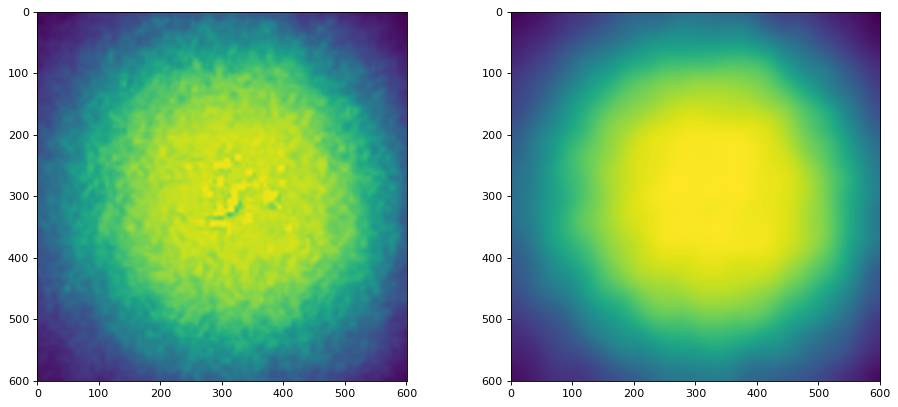

In [18]:
plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.imshow(source_data)

# we need to crop the image to the rectangular cuvette
# source_data = source_data[100:-100, 100:-100]

source_data_medfilt = sps.medfilt(source_data, kernel_size=15)
source_data_gaussfilt = gaussian_filter(source_data_medfilt, sigma=15)
source_data_filt_norm = source_data_gaussfilt / source_data_gaussfilt.max() * 10000

print(np.linalg.norm(source_data_gaussfilt-source_data_medfilt)/np.linalg.norm(source_data_medfilt))

plt.subplot(1,2,2)
plt.imshow(source_data_filt_norm)

In [19]:
# convert source data to the Fenics functin
trueSource = fem.Function(Q)
dofs = Q.tabulate_dof_coordinates()
    
for i in range(dofs.shape[0]):
#     dofs[i,0],dofs[i,1],dofs[i,2]
        
    if fem.near(dofs[i,2], rb_z):
        p_x = round((dofs[i,0] / rb_x) * (source_data.shape[1]-1))
        p_y = round((dofs[i,1] / rb_y) * (source_data.shape[0]-1))

        trueSource.vector()[i] = source_data_filt_norm[p_y, p_x]

Building point search tree to accelerate distance queries.
Computed bounding box tree with 139391 nodes for 69696 points.


Text(0.5, 1.0, 'FEM source data (trace)')

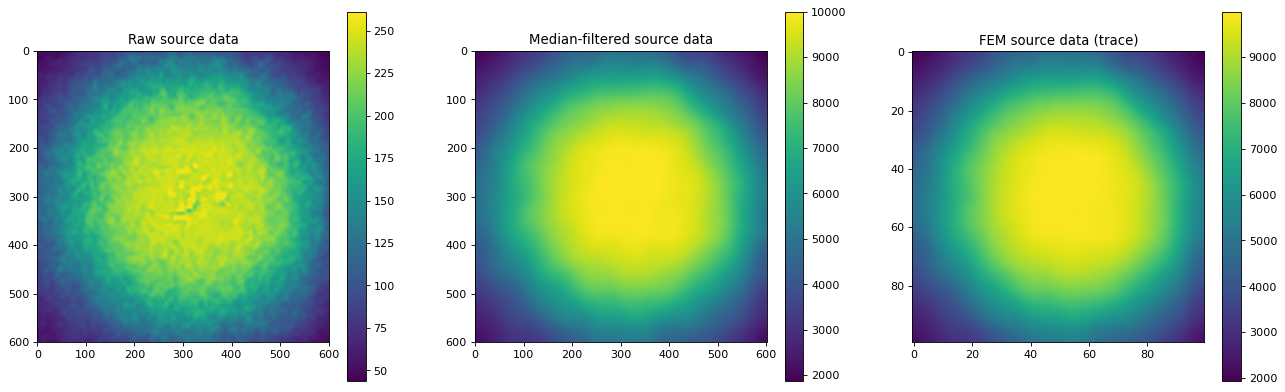

In [20]:
# plot the true source
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1,3,1)
img = plt.imshow(source_data)
plt.colorbar(img)
plt.title('Raw source data')

plt.subplot(1,3,2)
img = plt.imshow(source_data_filt_norm)
plt.colorbar(img)
plt.title('Median-filtered source data')

plt.subplot(1,3,3)
trace = Trace(trueSource, rb_z)
img = plt.imshow(trace)
plt.colorbar(img)
plt.title('FEM source data (trace)')

### Solving the system forward in time and generating synthetic observations

In [21]:
#UNIT test 1: is the "fake source" Sf = mu_axf*phi_x reconstructing the solution phi_x well? 

ux = fem.TrialFunction(Q)
vx = fem.TestFunction(Q)

ax_muax  = ax_form(ux, vx) 
rhs = trueSource/2*vx*fem.ds 

hatphi = fem.Function(Q)
phibar = fem.Function(Q)
Sf     = fem.Function(Q)
phiSf = fem.Function(Q)

print('State space dimension = ', phiSf.vector()[:].size)

fem.solve(ax_muax==rhs, hatphi, solver_parameters={'linear_solver':'mumps'})
print('Phi_x >= 0:  ', np.all(hatphi.vector()[:]>=0), '\n#(<0) = ', np.sum(hatphi.vector()[:]<0), '2norm % of (<0)', np.linalg.norm(hatphi.vector()[hatphi.vector()[:]<0])/np.linalg.norm(hatphi.vector()[:]), 'Min Phi_x = ', np.min(hatphi.vector()[:]))

fem.solve(ax_nomuaxf_form(ux, vx) == trueSource/2*vx*fem.ds, phibar, solver_parameters={'linear_solver':'mumps'})
print('Phi_bar >= 0: ', np.all(phibar.vector()[:]>=0), '\n#(<0) = ', np.sum(phibar.vector()[:]<0), '2norm % of (<0)', np.linalg.norm(phibar.vector()[phibar.vector()[:]<0])/np.linalg.norm(phibar.vector()[:]),'Min Phi_bar = ', np.min(phibar.vector()[:]))

diff_phibar_x = phibar.vector()[:] - hatphi.vector()[:]
print('Phi_bar >= Phi_x', np.all(diff_phibar_x>=0))#, phibar.vector()[diff_phibar_x<0],hatphi.vector()[diff_phibar_x<0])
    
if np.min(phibar.vector()[:])<0:
    print('WARNING: FEM solution Phi_bar has', np.sum(phibar.vector()[:]<0), 'negative components! Setting negatives to 0!')
    tmp_ind = phibar.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    phibar.vector()[:] = tmp_ind 

if np.min(hatphi.vector()[:])<0:
    print('WARNING: FEM solution Phi_x has', np.sum(hatphi.vector()[:]<0), ' negative components! Setting negatives to 0!')
    tmp_ind = hatphi.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    hatphi.vector()[:] = tmp_ind 

Sf.vector()[:] = np.multiply(mu_axf.vector()[:], hatphi.vector()[:])

ax0  = ax_nomuaxf_form(ux, vx) 
rhsSf = trueSource/2*vx*fem.ds - Sf*vx*fem.dx
print('WARNING: FEM interpolation error - if Sf in rhsSf is substituted by mu_axf*hatphi then Phi_Sf = Phi_x!')

fem.solve(ax0 ==rhsSf, phiSf, solver_parameters={'linear_solver':'mumps'})
print('Phi_Sf >= 0:  ', np.all(phiSf.vector()[:]>=0), '\n#(<0) = ', np.sum(phiSf.vector()[:]<0), 'Min Phi_Sf = ', np.min(phiSf.vector()[:]))

if np.min(phiSf.vector()[:])<0:
    print('WARNING: FEM solution Phi_Sf has ', np.sum(phiSf.vector()[:]<0), 'negative components', 'out of', phiSf.vector()[:].size,'Setting negatives to 0!')
    tmp_ind = phiSf.vector()[:]
    tmp_ind[tmp_ind<0] = 0
    phiSf.vector()[:] = tmp_ind 


print('FEM INterpolation error: \nRel. Rn-err: |Phi_x - Phi_Sf|  = ', np.linalg.norm(phiSf.vector()[:] - hatphi.vector()[:])/np.linalg.norm(hatphi.vector()[:]))
print('Rel. L2-err: |Phi_ex - Phi_Sf|  = ', np.sqrt(fem.assemble((hatphi-phiSf)**2*fem.dx))/np.sqrt(fem.assemble(hatphi**2*fem.dx)))



State space dimension =  13225
Solving linear variational problem.
Phi_x >= 0:   False 
#(<0) =  6 2norm % of (<0) 5.843034412025181e-05 Min Phi_x =  -5.180987038102521
Solving linear variational problem.
Phi_bar >= 0:  False 
#(<0) =  6 2norm % of (<0) 5.044607162053769e-05 Min Phi_bar =  -4.831271225974562
Phi_bar >= Phi_x False
Solving linear variational problem.
Phi_Sf >= 0:   False 
#(<0) =  6 Min Phi_Sf =  -5.179037073959811
FEM INterpolation error: 
Rel. Rn-err: |Phi_x - Phi_Sf|  =  0.0015388863843028371
Rel. L2-err: |Phi_ex - Phi_Sf|  =  0.0017215872903174557


In [22]:
is_dof_observable = np.array([observation_marker.inside(point, True) for point in dofs])
is_dof_near_boundary = np.array([near_boundary_marker.inside(point, True) for point in dofs])

In [23]:
S_emit = fem.assemble(am_form(ux, vx)).array()
mM = fem.assemble(ux*vx*fem.dx).array()*float(Gm)*float(ICG_absoption_coeff)
# mF = np.linalg.solve(S_emit,mM)

def compute_emission_solution(Sf):
    phi_em = fem.Function(Q)
    fem.solve(am_form(ux, vx)==Sf*vx*float(Gm)*float(ICG_absoption_coeff)*fem.dx, 
              phi_em, solver_parameters={'linear_solver':'mumps'})
    return phi_em

In [24]:
# mF = np.linalg.solve(S_emit,mM)

Solving linear variational problem.


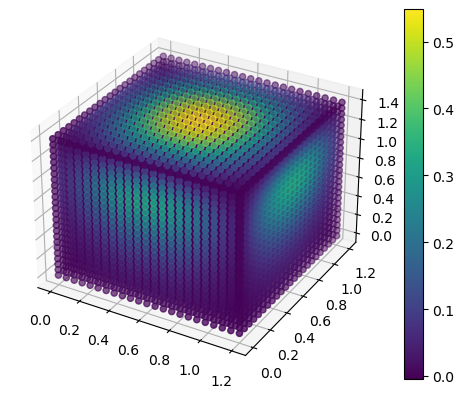

In [25]:
# creating synthetic observations
Sf.vector()[:] = np.multiply(XiPhantom.vector()[:], hatphi.vector()[:])
y_model = compute_emission_solution(Sf).vector()[:]
y_model[~is_dof_observable] = 0

y = fem.Function(Q)
y.vector()[:] = y_model

im3d = fem.plot(y)
plt.colorbar(im3d)

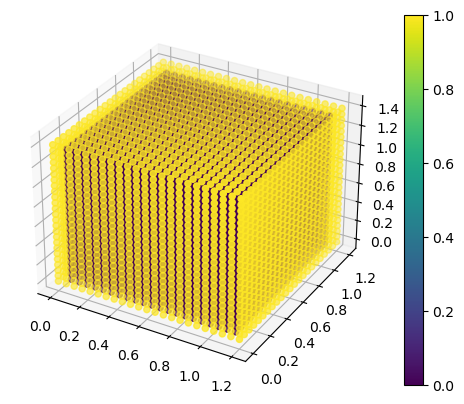

In [26]:
y_mask = fem.Function(Q)
tmp = np.zeros_like(y_mask.vector()[:])
tmp[is_dof_observable] = 1
y_mask.vector()[:] = tmp

im3d = fem.plot(y_mask)
plt.colorbar(im3d)

In [27]:
np.linalg.norm((y_model-y.vector()[:])*y_mask.vector()[:])/np.linalg.norm(y_model*y_mask.vector()[:])

0.0

In [28]:
y_tr_sign = y.vector()[:]

Dvar1 = cp.Parameter(shape=hatphi.vector()[:].shape[0], nonneg=True)
Dvar1.value = phibar.vector()[:]
# Dvar1.value = hatphi.vector()[:]

Svar1 = cp.Variable(shape=Q.dim(), nonneg=True)
Svar2 = cp.Variable(shape=Q.dim(), nonneg=True)

tikh = cp.Parameter(nonneg=True)
tikh.value = 1/TV_cubes_index.shape[0]
# tikh.value = 0
norm_bound = cp.Parameter(nonneg=True)
norm_bound.value = 1
reg_tol = cp.Parameter(nonneg=True)
reg_tol.value = 0.004
reg_tol.value = 0.01
EmissionEq_tol = cp.Parameter(nonneg=True)
# TODO: making it lower then 1e-4 results in worse reconstruction result and eventual failure
EmissionEq_tol.value   = 1e-4

TVreg = cp.tv(Svar1[TV_cubes_index[0,:]])
for jj in range(1,TV_cubes_index.shape[0]):
    node_reg = 1/TV_cubes_index[jj,:].sum()**(2/3)
    TVreg = TVreg + node_reg*cp.tv(Svar1[TV_cubes_index[jj,:].astype(bool)])

data_misfit_normalization = cp.Parameter(nonneg=True)
data_misfit_normalization.value = 1/np.linalg.norm(y_tr_sign*y_mask.vector()[:],2)**2

# 1e+5*
Cost  = data_misfit_normalization*cp.sum_squares(cp.multiply(Svar2 - y_tr_sign, y_mask.vector()[:])) + \
        tikh*TVreg + \
        norm_bound*cp.sum(Svar1[is_dof_near_boundary])
Constraints = [cp.sum(Svar1)>=3000, Svar1<=1, cp.norm(S_emit@Svar2-mM@(cp.multiply(Dvar1,Svar1))) <= EmissionEq_tol]

# Cost  = tikh*TVreg + \
#         norm_bound*cp.sum(Svar1[is_dof_near_boundary])
# Constraints = [cp.sum(Svar1)>=200, Svar1<=1, cp.norm(S_emit@Svar2-mM@Svar1) <= EmissionEq_tol, 
#                data_misfit_normalization*cp.sum_squares(cp.multiply(Svar2 - y_tr_sign, y_mask.vector()[:])) <= reg_tol]

# Cost  = data_misfit_normalization*cp.sum_squares(cp.multiply(mF@Svar1 - y_tr_sign, y_mask.vector()[:])) + \
#         tikh*TVreg + \
#         norm_bound*cp.sum(Svar1[is_dof_near_boundary])
# Constraints = [cp.sum(Svar1)>=3000, Svar1<=1]

# Cost  = tikh*TVreg + norm_bound*cp.sum(Svar1[is_dof_near_boundary])
# Constraints = [cp.sum(Svar1)>=200, Svar1<=1, 
#                data_misfit_normalization*cp.sum_squares(cp.multiply(mF@Svar1 - y_tr_sign, y_mask.vector()[:])) <= reg_tol]

prob = cp.Problem(cp.Minimize(Cost), Constraints)

# solver = cp.OSQP
# solver = cp.ECOS
solver = cp.MOSEK
if solver == cp.OSQP:
    # prob.solve(solver,verbose = True, eps_abs=5e-8, eps_rel=5e-8, max_iter=500)
    prob.solve(solver,verbose = True, eps_abs=5e-8, eps_rel=5e-8, max_iter=5000)
elif solver == cp.ECOS: 
    prob.solve(solver,verbose = True, max_iters=1000)
elif solver == cp.MOSEK:
    # dparam.intpnt_co_tol_mu_red
    prob.solve(solver,verbose = True, ignore_dpp = True, mosek_params={mosek.iparam.intpnt_solve_form: mosek.solveform.free, 
                                                    mosek.dparam.intpnt_co_tol_pfeas: 1e-8, 
                                                    mosek.dparam.intpnt_co_tol_infeas: 1e-12})
# The following parameters resulted in a very very minor improvements of the result
# mosek.dparam.intpnt_co_tol_rel_gap: 1e-12,
# mosek.dparam.intpnt_co_tol_mu_red: 1e-12,
# mosek.dparam.intpnt_co_tol_near_rel: 1    

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Nov 04 02:35:18 PM: Your problem has 26450 variables, 3 constraints, and 13229 parameters.
(CVXPY) Nov 04 02:35:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 04 02:35:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 04 02:35:18 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Nov 04 02:35:18 PM: Reduction chain: EvalParams -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Nov 04 02:35:18 PM: Applying reduction EvalParams
(CVXPY) Nov 04 02:35:18 PM: Applying reductio

In [29]:
# Svar1_orig = Svar1.value.copy()

In [30]:
Svar1.value[Svar1.value>0.5] = 1

In [31]:
gk    = cp.Parameter(len(XiPhantom.vector()[:]))
gk.value = XiPhantom.vector()[:]
# /float(ICG_absoption_coeff)
TVregk = cp.tv(gk[TV_cubes_index[0,:]])
for jj in range(1,TV_cubes_index.shape[0]):
    node_reg = 1/TV_cubes_index[jj,:].sum()**(2/3)
    TVregk = TVregk + node_reg*cp.tv(gk[TV_cubes_index[jj,:].astype(bool)])

# Svar_proj = 
# dmsft = data_misfit_normalization*cp.sum_squares(cp.multiply(Svar2 - y_tr_sign, y_mask.vector()[:]))
# Svar1 = gk
# dmsft      = (data_misfit_normalization*cp.sum_squares(cp.multiply(mF@cp.multiply(Dvar1, Svar1) - y_tr_sign, y_mask.vector()[:]))).value
dmsft      = (data_misfit_normalization*cp.sum_squares(cp.multiply(Svar2 - y_tr_sign, y_mask.vector()[:]))).value

mu_axf_est = fem.Function(Q)
mu_axf_est.vector()[:] = np.multiply(Dvar1.value, gk.value)
phi_em_est = compute_emission_solution(mu_axf_est)
dmsft_true = (data_misfit_normalization*cp.sum_squares(cp.multiply(phi_em_est.vector()[:] - y_tr_sign, y_mask.vector()[:]))).value

print('Data misfit = ', dmsft, 'TV=' , (tikh*TVreg).value)
print('True misfit = ', dmsft_true,'TV= ', (tikh*TVregk).value)
print('Cost = ', Cost.value, 'True cost = ', dmsft_true + (tikh*TVregk).value)
print('Emission equation constraint = ', cp.norm(S_emit@Svar2-mM@(cp.multiply(Dvar1,Svar1))).value, 'true = ', cp.norm(S_emit@phi_em_est.vector()[:]-mM@(cp.multiply(Dvar1,gk))).value)
print('Constraint = ', cp.sum(Svar1).value, 'True constraint = ',cp.sum(gk).value)
print('Boudnary L1 regularisation = ', (norm_bound*cp.sum(Svar1[is_dof_near_boundary])).value)
# print('Cnst.misfit = ', data_misfit_normalization*cp.sum_squares(mF@np.ones_like(Svar1.value)*0.041 - y_tr_scaled).value)

Solving linear variational problem.
Data misfit =  0.003806539606016615 TV= 5.132539709453134e-08
True misfit =  0.28517446810183145 TV=  0.0
Cost =  0.00380659093141371 True cost =  0.28517446810183145
Emission equation constraint =  0.0016051747769556875 true =  9.023670054673662e-16
Constraint =  3019.1729735458625 True constraint =  3825.0
Boudnary L1 regularisation =  0.0


Text(0.5, 0.92, 'Phantom reconstruction difference')

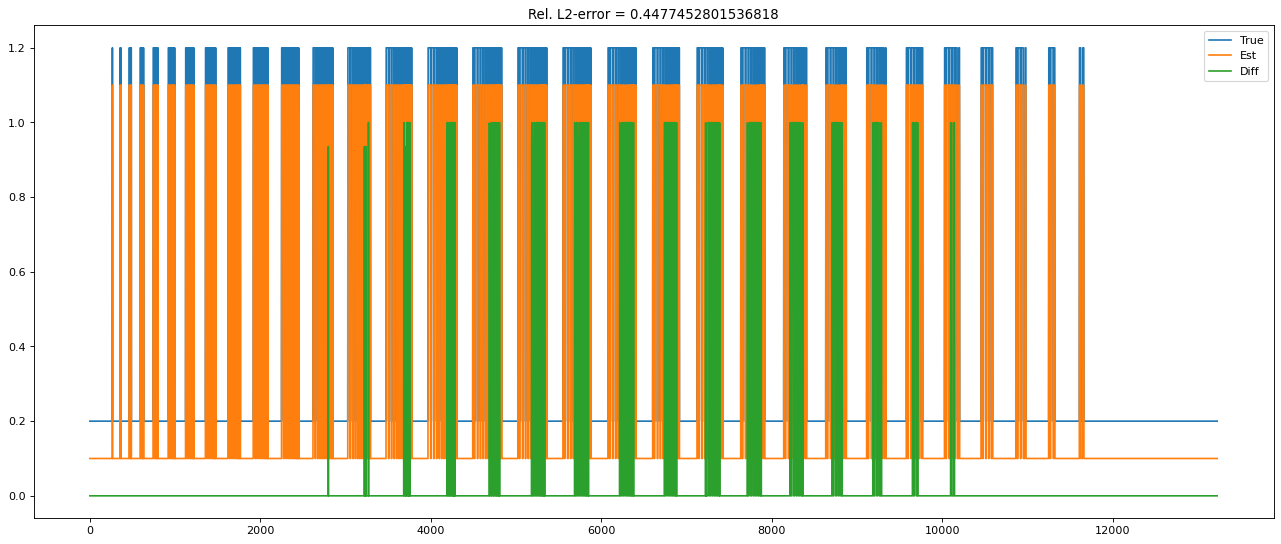

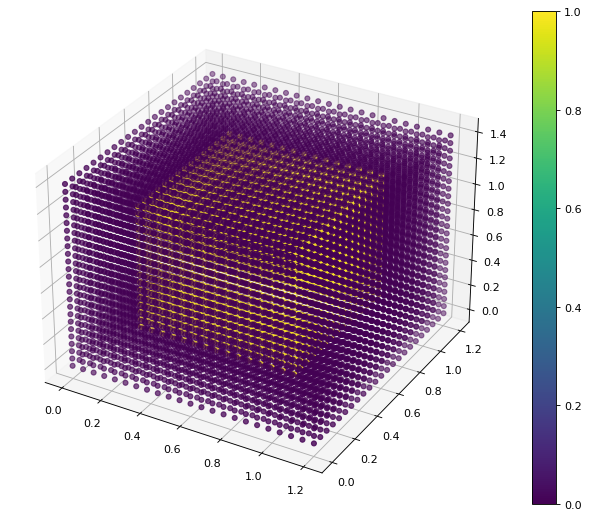

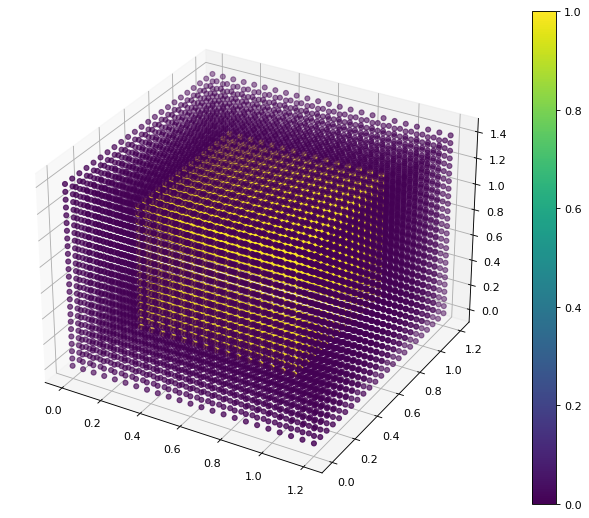

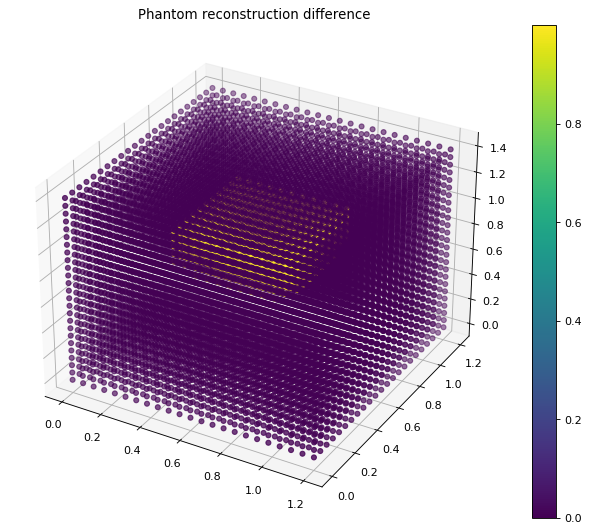

In [32]:
plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(XiPhantom.vector()[:]+0.2,label='True') 
plt.plot(Svar1.value+0.1,label='Est')
plt.plot(XiPhantom.vector()[:]-Svar1.value,label='Diff')
msg = np.array(("Rel. L2-error = "))
sol1 = fem.Function(Q)
sol1.vector()[:] = Svar1.value
err_str = np.format_float_positional(np.sqrt(fem.assemble((XiPhantom-sol1)**2*fem.dx)/fem.assemble((XiPhantom)**2*fem.dx)))
plt.title(np.char.add(msg,err_str))
plt.legend()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
sol1.set_allow_extrapolation(True)
u = fem.project(sol1, Q_low)
img1 = fem.plot(u)
# img1 = fem.plot(sol1)
plt.colorbar(img1)

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
sol1.vector()[:] = gk.value
u = fem.project(sol1, Q_low)
img1 = fem.plot(u)
plt.colorbar(img1)

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
sol1.vector()[:] = gk.value - Svar1.value
u = fem.project(sol1, Q_low)
img1 = fem.plot(u)
plt.colorbar(img1)
plt.title('Phantom reconstruction difference')

# plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
# # plt.subplot(1,2,1)
# sol1.vector()[:] = mF@gk.value*is_dof_observable.astype(float)
# img1 = fem.plot(sol1)
# plt.colorbar(img1)
# plt.title('Reconstructed surface emission')

# plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
# # plt.subplot(1,2,2)
# sol1.vector()[:] = is_dof_near_boundary.astype(float)
# # sol1.vector()[:] = y_tr_sign
# img1 = fem.plot(sol1)
# plt.colorbar(img1)
# plt.title('Observed emission')


In [33]:
sol1 = fem.Function(Q)
sol1.vector()[:] = Svar1.value
print('Phantom reconstruction error: continuous = ', np.sqrt(fem.assemble((XiPhantom-sol1)**2*fem.dx)/fem.assemble((XiPhantom)**2*fem.dx)), 
      ';  discrete = ', np.linalg.norm(XiPhantom.vector()[:]-sol1.vector()[:])/np.linalg.norm(XiPhantom.vector()[:]))
print('hatphi  reconstruction error: continuous = ', np.sqrt(fem.assemble((hatphi-phibar)**2*fem.dx)/fem.assemble((hatphi)**2*fem.dx)),
      ';  discrete = ', np.linalg.norm(hatphi.vector()[:]-phibar.vector()[:])/np.linalg.norm(hatphi.vector()[:]))

Phantom reconstruction error: continuous =  0.4477452801536818 ;  discrete =  0.4584017242704218
hatphi  reconstruction error: continuous =  0.1653279049744273 ;  discrete =  0.14658014419447205


In [34]:
XiPhantom_est_0 = Svar1.value.copy()
XiPhantom_est_prev = Svar1.value.copy()
hatphi_prev = hatphi.vector()[:].copy()

In [35]:
hatphi_est = fem.Function(Q)

In [36]:
def project_to_nonnegative(ff):
    tmp = ff.vector()[:]
    tmp[tmp<0] = 0
    ff.vector()[:] = tmp

In [40]:
phantom_diff = 1
max_iter = 10
itr = 1

while (phantom_diff > 0.001) and (itr < max_iter):
    print('====================== iteration: ', itr, '======================')
    mu_axf.vector()[:] = ICG_absoption_coeff*Svar1.value

    fem.solve(ax_muax==rhs, hatphi_est, solver_parameters={'linear_solver':'mumps'})
    project_to_nonnegative(hatphi_est)

    Dvar1.value = hatphi_est.vector()[:]
    prob.solve(solver,verbose = False, ignore_dpp = True, warm_start=True,
               mosek_params={mosek.iparam.intpnt_solve_form: mosek.solveform.free, 
                             mosek.dparam.intpnt_co_tol_pfeas: 1e-8, 
                             mosek.dparam.intpnt_co_tol_infeas: 1e-12})
    # Svar1.value[Svar1.value>=0.5] = 1

    sol1 = fem.Function(Q)
    sol1.vector()[:] = Svar1.value
    print('Phantom reconstruction error: continuous = ', np.sqrt(fem.assemble((XiPhantom-sol1)**2*fem.dx)/fem.assemble((XiPhantom)**2*fem.dx)), 
          ';  discrete = ', np.linalg.norm(XiPhantom.vector()[:]-sol1.vector()[:])/np.linalg.norm(XiPhantom.vector()[:]))
    print('hatphi  reconstruction error: continuous = ', np.sqrt(fem.assemble((hatphi-hatphi_est)**2*fem.dx)/fem.assemble((hatphi)**2*fem.dx)),
          ';  discrete = ', np.linalg.norm(hatphi.vector()[:]-hatphi_est.vector()[:])/np.linalg.norm(hatphi.vector()[:]))

    phantom_diff = np.linalg.norm(XiPhantom_est_prev - Svar1.value)/np.linalg.norm(XiPhantom_est_prev)
    print('Iteration phantom difference: ', phantom_diff)
    print('Iteration hatphi  difference: ', np.linalg.norm(hatphi_prev - hatphi_est.vector()[:])/np.linalg.norm(hatphi_prev))

    mu_axf_est = fem.Function(Q)
    mu_axf_est.vector()[:] = np.multiply(Dvar1.value, Svar1.value)
    phi_em_est = compute_emission_solution(mu_axf_est).vector()[:]
    dmsft      = (data_misfit_normalization*cp.sum_squares(cp.multiply(phi_em_est - y_tr_sign, y_mask.vector()[:]))).value

    mu_axf_gk = fem.Function(Q)
    mu_axf_gk.vector()[:] = np.multiply(Dvar1.value, gk.value)
    phi_em_gk = compute_emission_solution(mu_axf_gk).vector()[:]    
    dmsft_true = (data_misfit_normalization*cp.sum_squares(cp.multiply(phi_em_gk - y_tr_sign, y_mask.vector()[:]))).value

    print('Data misfit = ', dmsft, 'TV=' , (tikh*TVreg).value)
    print('Data misfit for true phantom = ', dmsft_true,'TV= ', (tikh*TVregk).value)
    print('')
        
    XiPhantom_est_prev = Svar1.value.copy()
    hatphi_prev = hatphi_est.vector()[:].copy()
    
    itr = itr+1

====================== iteration:  1 ======================
Solving linear variational problem.
Phantom reconstruction error: continuous =  0.12570017263924937 ;  discrete =  0.13104632973992209
hatphi  reconstruction error: continuous =  0.0 ;  discrete =  0.0
Iteration phantom difference:  0.13104632973992209
Iteration hatphi  difference:  0.0
Solving linear variational problem.
Solving linear variational problem.
Data misfit =  4.7052836313864626e-05 TV= 4.054038079845512e-08
Data misfit for true phantom =  0.0 TV=  0.0

====================== iteration:  2 ======================
Solving linear variational problem.
Phantom reconstruction error: continuous =  0.15575361100748833 ;  discrete =  0.16204195338360722
hatphi  reconstruction error: continuous =  0.0008135699972124158 ;  discrete =  0.0007204458363637628
Iteration phantom difference:  0.03374849887147313
Iteration hatphi  difference:  0.0007204458363637628
Solving linear variational problem.
Solving linear variational probl

In [38]:
gk    = cp.Parameter(len(XiPhantom.vector()[:]))
gk.value = XiPhantom.vector()[:]
# /float(ICG_absoption_coeff)
TVregk = cp.tv(gk[TV_cubes_index[0,:]])
for jj in range(1,TV_cubes_index.shape[0]):
    node_reg = 1/TV_cubes_index[jj,:].sum()**(2/3)
    TVregk = TVregk + node_reg*cp.tv(gk[TV_cubes_index[jj,:].astype(bool)])

# Svar_proj = 
# dmsft = data_misfit_normalization*cp.sum_squares(cp.multiply(Svar2 - y_tr_sign, y_mask.vector()[:]))
# Svar1 = gk
# dmsft      = (data_misfit_normalization*cp.sum_squares(cp.multiply(mF@cp.multiply(Dvar1, Svar1) - y_tr_sign, y_mask.vector()[:]))).value
dmsft      = (data_misfit_normalization*cp.sum_squares(cp.multiply(Svar2 - y_tr_sign, y_mask.vector()[:]))).value

mu_axf_est = fem.Function(Q)
mu_axf_est.vector()[:] = np.multiply(Dvar1.value, gk.value)
phi_em_est = compute_emission_solution(mu_axf_est)
dmsft_true = (data_misfit_normalization*cp.sum_squares(cp.multiply(phi_em_est.vector()[:] - y_tr_sign, y_mask.vector()[:]))).value

print('Data misfit = ', dmsft, 'TV=' , (tikh*TVreg).value)
print('True misfit = ', dmsft_true,'TV= ', (tikh*TVregk).value)
print('Cost = ', Cost.value, 'True cost = ', dmsft_true + (tikh*TVregk).value)
print('Emission equation constraint = ', cp.norm(S_emit@Svar2-mM@(cp.multiply(Dvar1,Svar1))).value, 'true = ', cp.norm(S_emit@phi_em_est.vector()[:]-mM@(cp.multiply(Dvar1,gk))).value)
print('Constraint = ', cp.sum(Svar1).value, 'True constraint = ',cp.sum(gk).value)
print('Boudnary L1 regularisation = ', (norm_bound*cp.sum(Svar1[is_dof_near_boundary])).value)
# print('Cnst.misfit = ', data_misfit_normalization*cp.sum_squares(mF@np.ones_like(Svar1.value)*0.041 - y_tr_scaled).value)


Solving linear variational problem.
Data misfit =  1.1846769093035085e-06 TV= 0.0
True misfit =  0.0 TV=  0.0
Cost =  1.1846769093035085e-06 True cost =  0.0
Emission equation constraint =  0.00016583415288182554 true =  5.644690380423752e-16
Constraint =  3825.0 True constraint =  3825.0
Boudnary L1 regularisation =  0.0


Text(0.5, 0.92, 'Phantom reconstruction difference')

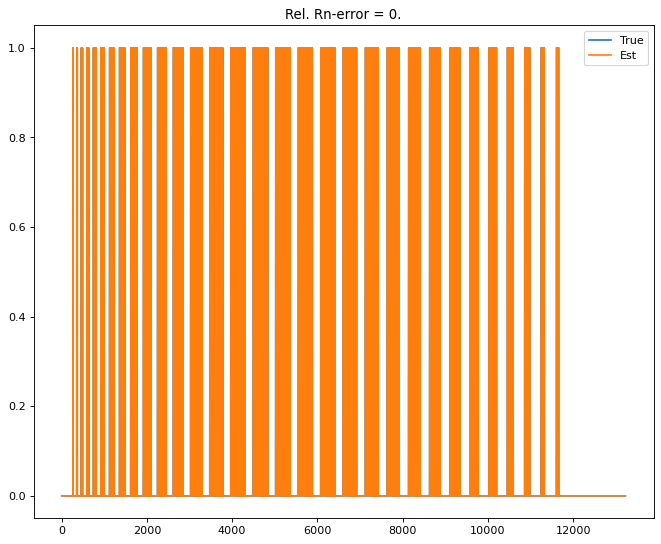

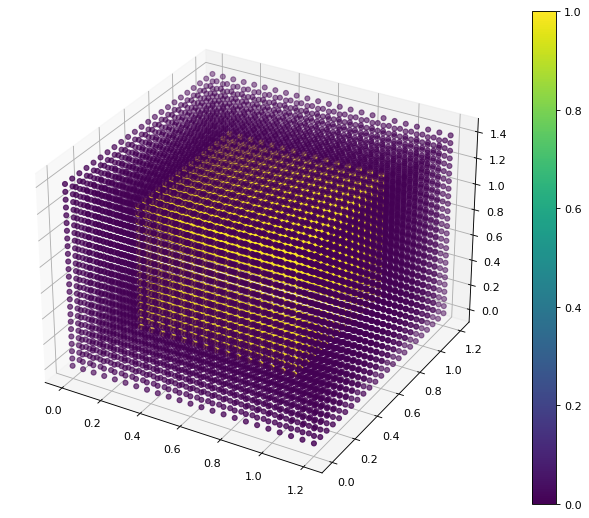

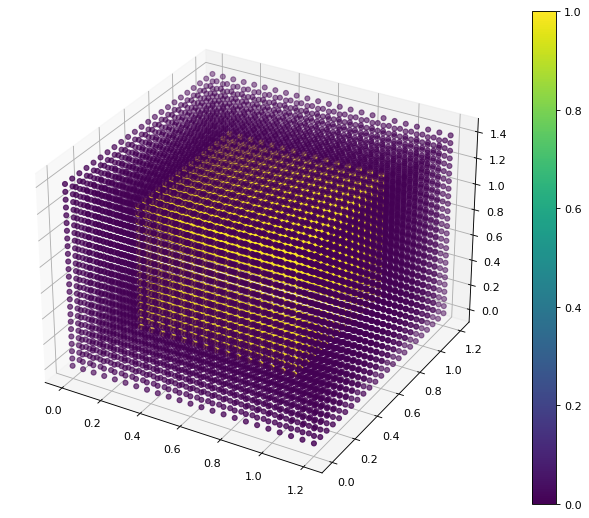

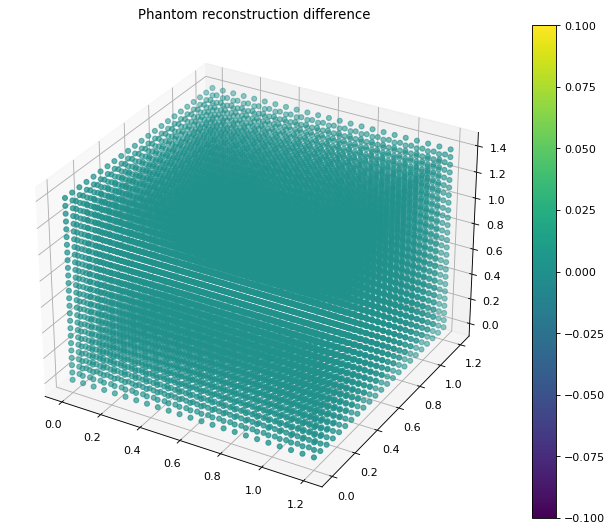

In [39]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(XiPhantom.vector()[:],label='True') 
plt.plot(Svar1.value,label='Est') 
msg = np.array(("Rel. Rn-error = "))
sol1 = fem.Function(Q)
sol1.vector()[:] = Svar1.value
err_str = np.format_float_positional(np.sqrt(fem.assemble((XiPhantom-sol1)**2*fem.dx)/fem.assemble((XiPhantom)**2*fem.dx)))
plt.title(np.char.add(msg,err_str))
plt.legend()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
u = fem.project(sol1, Q_low)
img1 = fem.plot(u)
plt.colorbar(img1)

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
sol1.vector()[:] = gk.value
u = fem.project(sol1, Q_low)
img1 = fem.plot(u)
plt.colorbar(img1)

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
sol1.vector()[:] = gk.value - Svar1.value
# + np.ones_like(Svar1.value)
u = fem.project(sol1, Q_low)
img1 = fem.plot(u)
plt.colorbar(img1)
plt.title('Phantom reconstruction difference')

# plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
# # plt.subplot(1,2,1)
# sol1.vector()[:] = mF@gk.value*is_dof_observable.astype(float)
# img1 = fem.plot(sol1)
# plt.colorbar(img1)
# plt.title('Reconstructed surface emission')

# plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
# # plt.subplot(1,2,2)
# # sol1.vector()[:] = is_dof_near_boundary.astype(float)
# sol1.vector()[:] = y_tr_sign
# img1 = fem.plot(sol1)
# plt.colorbar(img1)
# plt.title('Observed emission')
